In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


from data.datasets import get_data, flatten_dataset
from models.diffusion import *
from models.latent import *
from utils import *
from tensor_utils import *

from specmf.models import Graph

torch.set_default_dtype(torch.float32)

In [2]:
device = torch.device('mps')
print("MPS Built:", torch.backends.mps.is_built())
print("MPS Available:", torch.backends.mps.is_available())

MPS Built: True
MPS Available: True


### Load config and initialize vars

In [3]:
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Data configuration
data_config = config["data"]
data_name = data_config["data_name"]
n_samples = data_config["n_samples"]
n_samples_graph = data_config["n_samples_graph"]
latent_dim = data_config["latent_dim"]

# Encoder-decoder model
encdec_model_config = config["models"]["encoder-decoder"]
encdec_head = encdec_model_config["head"]
encdec_config = encdec_model_config["model_config"]

# Encoder-decoder training
encdec_training_config = config["training"]["encoder_decoder"]
encdec_num_epochs = encdec_training_config["num_epochs"]
encdec_n_batch = encdec_training_config["n_batch"]
encdec_learning_rate = encdec_training_config["learning_rate"]
encdec_log_interval = encdec_training_config["log_interval"]

# Diffusion model
diffusion_model_config = config["models"]["diffusion"]
time_embed_dim = diffusion_model_config["time_embed_dim"]
diffusion_hidden_units = diffusion_model_config["hidden_units"]
diffusion_depth = diffusion_model_config["depth"]
diffusion_dropout = diffusion_model_config["dropout"]
diffusion_use_residual = diffusion_model_config["use_residual"]

# Diffusion training
diffusion_training_config = config["training"]["diffusion"]
diffusion_num_epochs = diffusion_training_config["num_epochs"]
diffusion_batch_size = diffusion_training_config["batch_size"]
diffusion_learning_rate = diffusion_training_config["learning_rate"]
diffusion_weight_decay = diffusion_training_config["weight_decay"]
timesteps = diffusion_training_config["timesteps"]
beta_bounds = tuple(diffusion_training_config["beta_bounds"])
diffusion_log_interval = diffusion_training_config["log_interval"]

# print(yaml.dump(config))

### Load data and create graph

In [4]:
# Load data
X = get_data(
    data_name=data_name,
    n_samples=n_samples,
).to(device)

X, shape_X = flatten_dataset(X, return_shape=True)  # Shape: (n_samples, dim1 * dim2)

_, dim1, dim2 = shape_X

X_g = X[:n_samples_graph].to(device)

print(f"{X.shape=}")
print(f"{X_g.shape=}")

Loading MNIST dataset...
Sampling 50000 images...
X.shape=torch.Size([50000, 784])
X_g.shape=torch.Size([5000, 784])


In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'method': 'full',
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}

graph = Graph(
    data=X_g.detach().cpu().numpy(),
    **graph_config,
)

# Compute graph laplacian and eigenvectors
L = graph.graph_laplacian
_, eigvecs = graph.laplacian_eig()

### Latent space

In [6]:
# Compute the embedding z
Z_g = torch.tensor(eigvecs[:, :latent_dim]).float().to(device)

# Compute linear encoder and decoder
decoder_matrix = X_g.T @ Z_g
linear_decoder = LinearEmbedding(decoder_matrix)

encoder_matrix = compute_linear_transformation(
    X_g.T.detach().cpu(),
    Z_g.T.detach().cpu(),
).to(device)
linear_encoder = LinearEmbedding(encoder_matrix)

Z_l = linear_encoder(X).to(device)
print(X.shape, Z_l.shape)

torch.Size([50000, 784]) torch.Size([50000, 50])


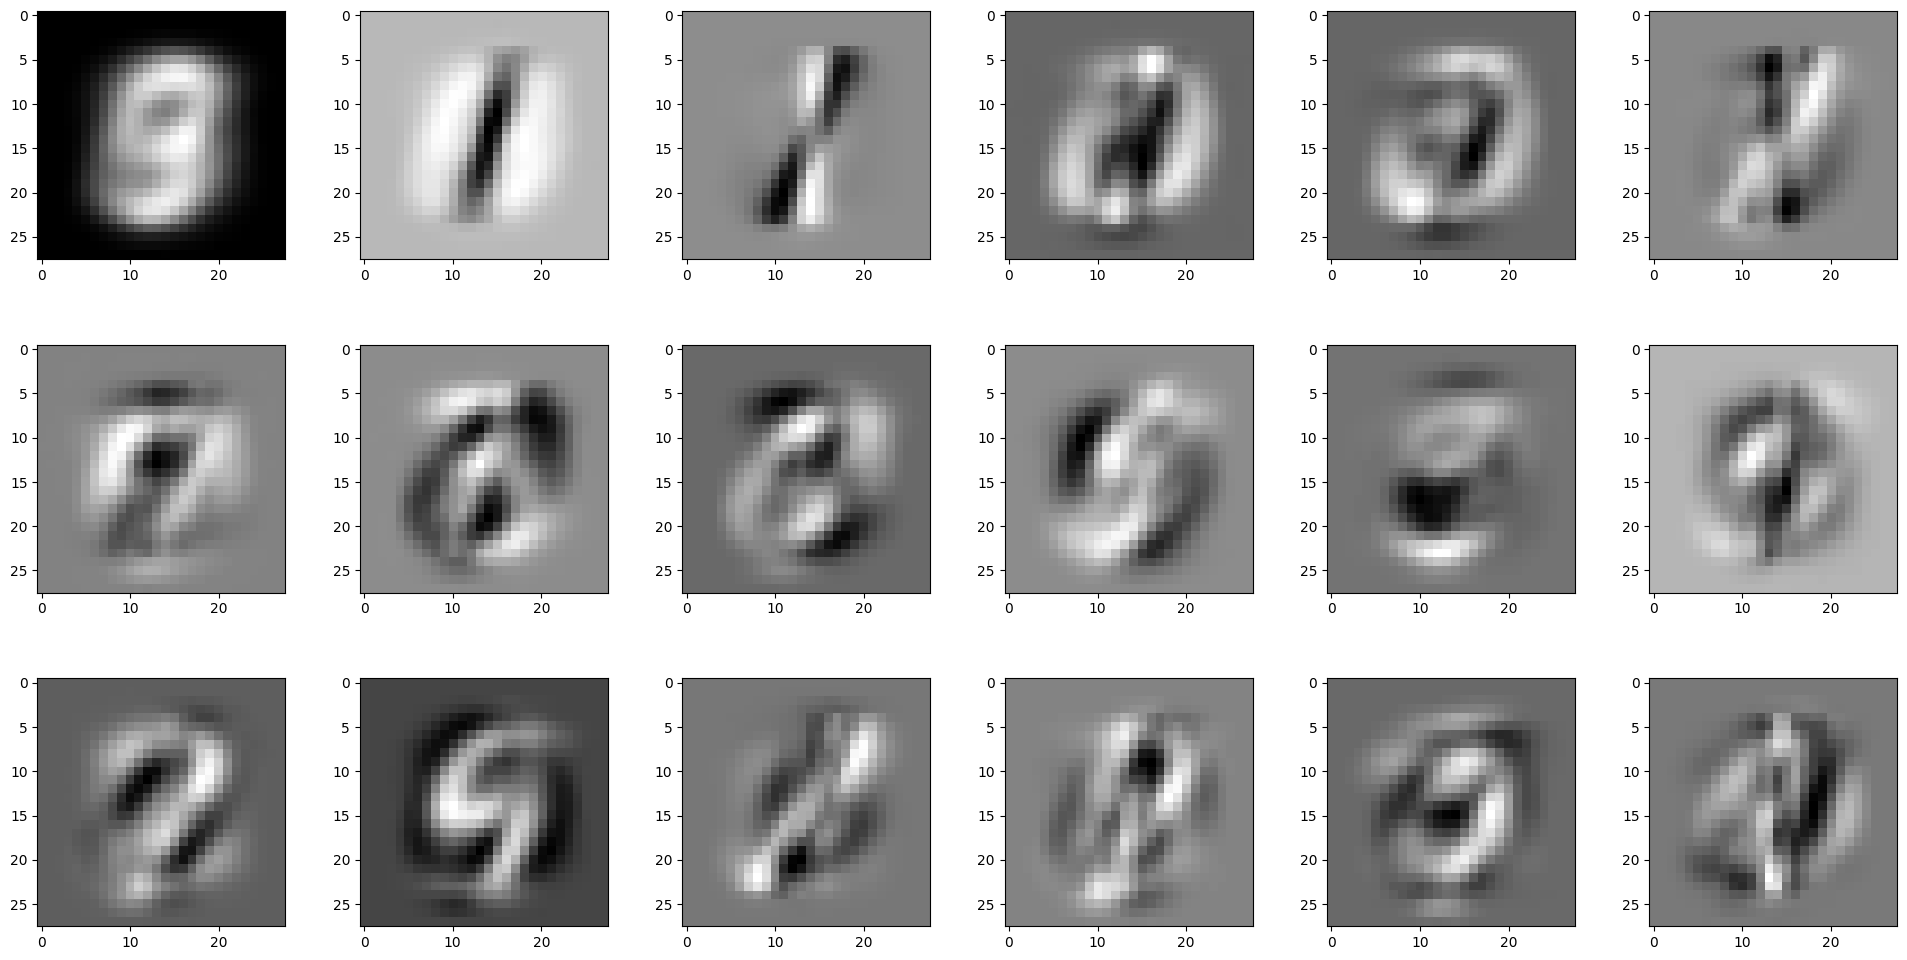

In [7]:
U = decoder_matrix.detach().cpu().numpy()
fig, axs = plt.subplots(3, 6, figsize=(24, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

i = 0
for r in range(3):
    for c in range(6):
        axs[r, c].imshow(U[:, i].reshape(dim1, dim2), cmap='gray')
        i += 1

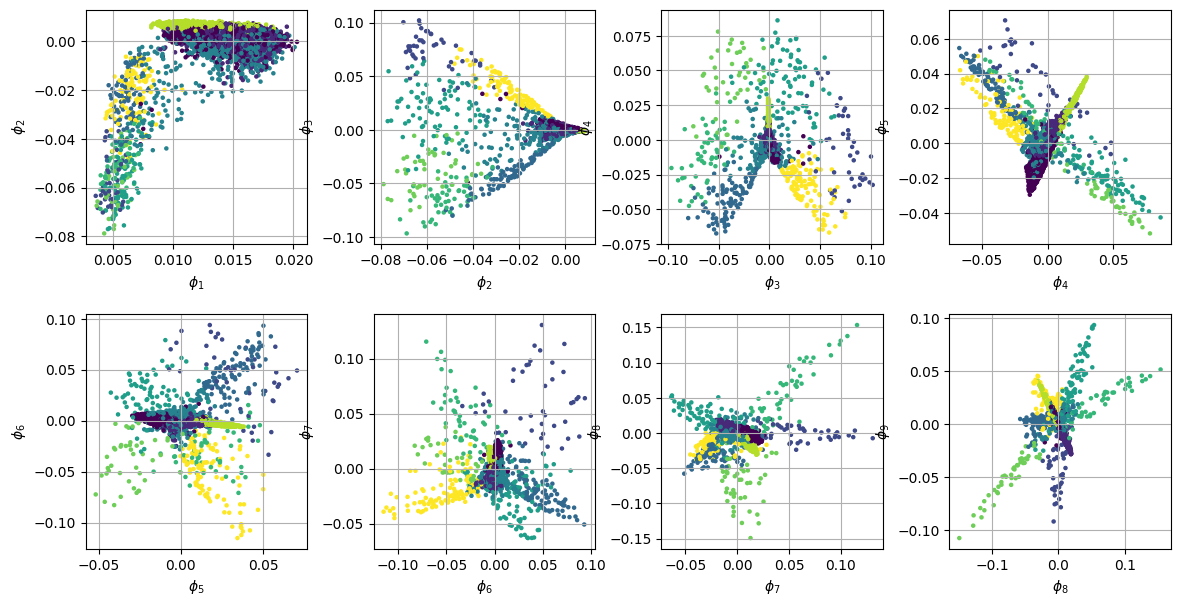

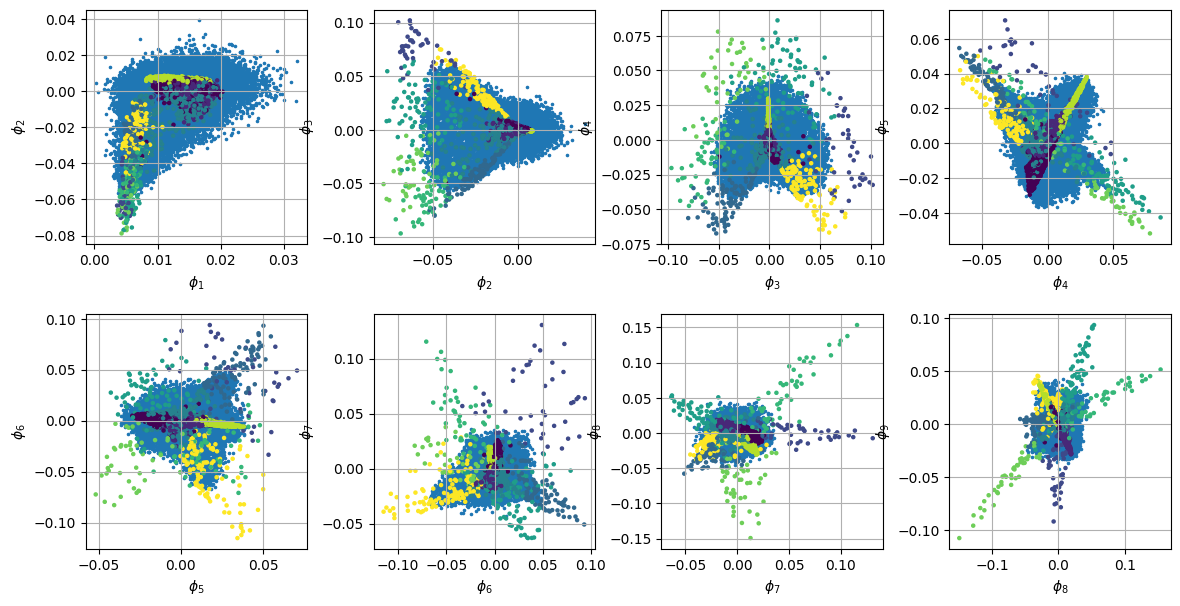

In [8]:
inds_centroids, labels = graph.cluster(n=10)

_Z_g = Z_g.detach().cpu().numpy()
_Z_l = Z_l.detach().cpu().numpy()

fig, axs = plt.subplots(2, 4, figsize=(14, 7))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(8):
    r, c = i//4, i%4
    x, y = _Z_g[:, i], _Z_g[:, i+1]
    axs[r, c].scatter(x, y, s=5, c=labels, cmap='viridis')
    axs[r, c].grid('on')
    axs[r, c].set_xlabel(fr"$\phi_{i+1}$")
    axs[r, c].set_ylabel(fr"$\phi_{i+2}$")


fig, axs = plt.subplots(2, 4, figsize=(14, 7))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(8):
    r, c = i//4, i%4
    x, y = _Z_l[:, i], _Z_l[:, i+1]
    axs[r, c].scatter(x, y, s=2.5)
    x, y = _Z_g[:, i], _Z_g[:, i+1]
    axs[r, c].scatter(x, y, s=5, c=labels, cmap='viridis')
    axs[r, c].grid('on')
    axs[r, c].set_xlabel(fr"$\phi_{i+1}$")
    axs[r, c].set_ylabel(fr"$\phi_{i+2}$")

tensor(-0.2708) tensor(1.1617)
Error decoder: 0.3415811565425496
Error encoder: 0.5491030909536891
Error encoded-decoded: 0.3126961482163165


Text(0.5, 1.0, 'Encoded-decoded image')

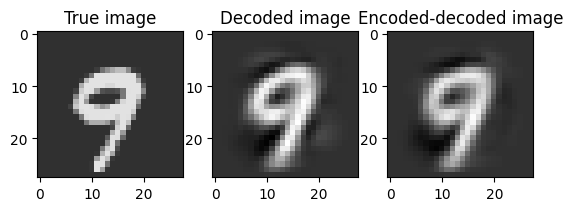

In [9]:
sample_ind = np.random.randint(0, X_g.shape[0])

x_true = X_g[sample_ind, :].reshape(1, -1)
z_true = Z_g[sample_ind, :].reshape(1, -1)

x_decoded = linear_decoder(z_true)
x_encoded = linear_encoder(x_true)
x_encoded_decoded = linear_decoder(x_encoded)

x_true = x_true.detach().cpu()
z_true = z_true.detach().cpu()
x_decoded = x_decoded.detach().cpu()
x_encoded = x_encoded.detach().cpu()
x_encoded_decoded = x_encoded_decoded.detach().cpu()

vmin = min(x_true.min(), x_decoded.min(), x_encoded_decoded.min())
vmax = max(x_true.max(), x_decoded.max(), x_encoded_decoded.max())
print(vmin, vmax)

# Errors
error_decoder = torch.norm(x_true - x_decoded).item() / torch.norm(x_true).item()
error_encoder = torch.norm(z_true - x_encoded).item() / torch.norm(z_true).item()
error_encoded_decoded = torch.norm(x_true - x_encoded_decoded).item() / torch.norm(x_true).item()

print(f"Error decoder: {error_decoder}")
print(f"Error encoder: {error_encoder}")
print(f"Error encoded-decoded: {error_encoded_decoded}")


fig, ax = plt.subplots(1, 3)
ax[0].imshow(x_true.reshape(dim1, dim2), cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title('True image')
ax[1].imshow(x_decoded.reshape(dim1, dim2), cmap='gray', vmin=vmin, vmax=vmax)
ax[1].set_title('Decoded image')
ax[2].imshow(x_encoded_decoded.reshape(dim1, dim2), cmap='gray', vmin=vmin, vmax=vmax)
ax[2].set_title('Encoded-decoded image')

Text(0.5, 1.0, 'Decoded image')

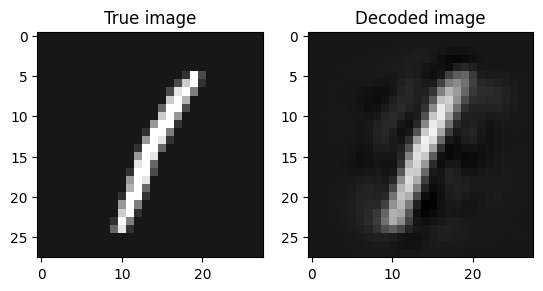

In [10]:
sample_ind = np.random.randint(0, X.shape[0])

x_true = X[sample_ind, :].reshape(1, -1)
z_l = Z_l[sample_ind, :].reshape(1, -1)

x_decoded = linear_decoder(z_l)

x_true = x_true.detach().cpu()
z_l = z_l.detach().cpu()
x_decoded = x_decoded.detach().cpu()

vmin = min(x_true.min(), x_decoded.min())
vmax = max(x_true.max(), x_decoded.max())

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_true.reshape(dim1, dim2), cmap='gray', vmin=vmin, vmax=vmax)
ax[0].set_title('True image')
ax[1].imshow(x_decoded.reshape(dim1, dim2), cmap='gray', vmin=vmin, vmax=vmax)
ax[1].set_title('Decoded image')


#### Train encoder and decoder

In [11]:
supervised_dataloader = DataLoader(
    TensorDataset(X_g, Z_g),
    batch_size=n_samples_graph // encdec_n_batch,
    shuffle=True,
)

unsupervised_dataloader = DataLoader(
    TensorDataset(X),
    batch_size=n_samples // encdec_n_batch,
    shuffle=True,
)

In [12]:
if encdec_head == "CNN":
    head_enc = CNNHead(**encdec_config)
    head_dec = CNNHead(**encdec_config)
elif encdec_head == "UNet":
    head_enc = UNetHead(**encdec_config)
    head_dec = UNetHead(**encdec_config)

# Encoder
encoder = LatentEmbedding(
    data_shape=(1, 1, latent_dim,),
    backbone=linear_encoder,
    head=head_enc,
).to(device)

print("Encoder parameters count:")
count_parameters(encoder)

# Decoder
decoder = LatentEmbedding(
    data_shape=(1, dim1, dim2,),
    backbone=linear_decoder,
    head=head_dec,
).to(device)

print("\nDecoder parameters count:")
count_parameters(decoder)

Encoder parameters count:
+---------------------------+----------------+------------+
|          Modules          |     Shape      | Parameters |
+---------------------------+----------------+------------+
| head.conv_layers.0.weight | [32, 1, 3, 3]  |    288     |
|  head.conv_layers.0.bias  |      [32]      |     32     |
| head.conv_layers.1.weight | [32, 32, 3, 3] |    9216    |
|  head.conv_layers.1.bias  |      [32]      |     32     |
| head.conv_layers.2.weight | [1, 32, 3, 3]  |    288     |
|  head.conv_layers.2.bias  |      [1]       |     1      |
+---------------------------+----------------+------------+
Total Trainable Parameters: 9857

Decoder parameters count:
+---------------------------+----------------+------------+
|          Modules          |     Shape      | Parameters |
+---------------------------+----------------+------------+
| head.conv_layers.0.weight | [32, 1, 3, 3]  |    288     |
|  head.conv_layers.0.bias  |      [32]      |     32     |
| head.conv_la

In [13]:
autoencoder_optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=encdec_learning_rate,
)

for epoch in range(encdec_num_epochs):

    encoder.train()
    decoder.train()

    loss_supervised = 0.0
    loss_unsupervised = 0.0
    batch_count = 0
    
    for batch_s, batch_us in zip(supervised_dataloader, unsupervised_dataloader):
        x_g, z_g = batch_s
        x = batch_us[0]

        autoencoder_optimizer.zero_grad()

        z_hat = encoder(x_g)
        loss_latent = F.mse_loss(z_hat, z_g)
        loss_latent.backward()
        loss_supervised += loss_latent.item()

        z_hat = encoder(x)
        x_hat = decoder(z_hat)
        loss_recon = F.mse_loss(x_hat, x)
        loss_recon.backward()
        loss_unsupervised += loss_recon.item()

        autoencoder_optimizer.step()
        batch_count += 1

    loss_supervised /= batch_count
    loss_unsupervised /= batch_count

    if (epoch + 1) % encdec_log_interval == 0:
        print(f"Epoch {epoch+1} : "
                f"Supervised Loss: {loss_supervised:.5f}, "
                f"Unsupervised Loss: {loss_unsupervised:.5f}")

    encoder.eval()
    decoder.eval()

Epoch 10 : Supervised Loss: 0.00009, Unsupervised Loss: 0.02210
Epoch 20 : Supervised Loss: 0.00009, Unsupervised Loss: 0.02158
Epoch 30 : Supervised Loss: 0.00009, Unsupervised Loss: 0.02122
Epoch 40 : Supervised Loss: 0.00009, Unsupervised Loss: 0.02082
Epoch 50 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01969
Epoch 60 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01871
Epoch 70 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01824
Epoch 80 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01782
Epoch 90 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01739
Epoch 100 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01712
Epoch 110 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01699
Epoch 120 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01688
Epoch 130 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01679
Epoch 140 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01672
Epoch 150 : Supervised Loss: 0.00009, Unsupervised Loss: 0.01665
Epoch 160 : Supervised Loss: 0.000

### Compute latent representation for the whole dataset

In [14]:
with torch.no_grad():
    Z = encoder(X)
    X_hat = decoder(Z)

Spectral clustering was already performed with the same number of clusters. Returning previous clusters.


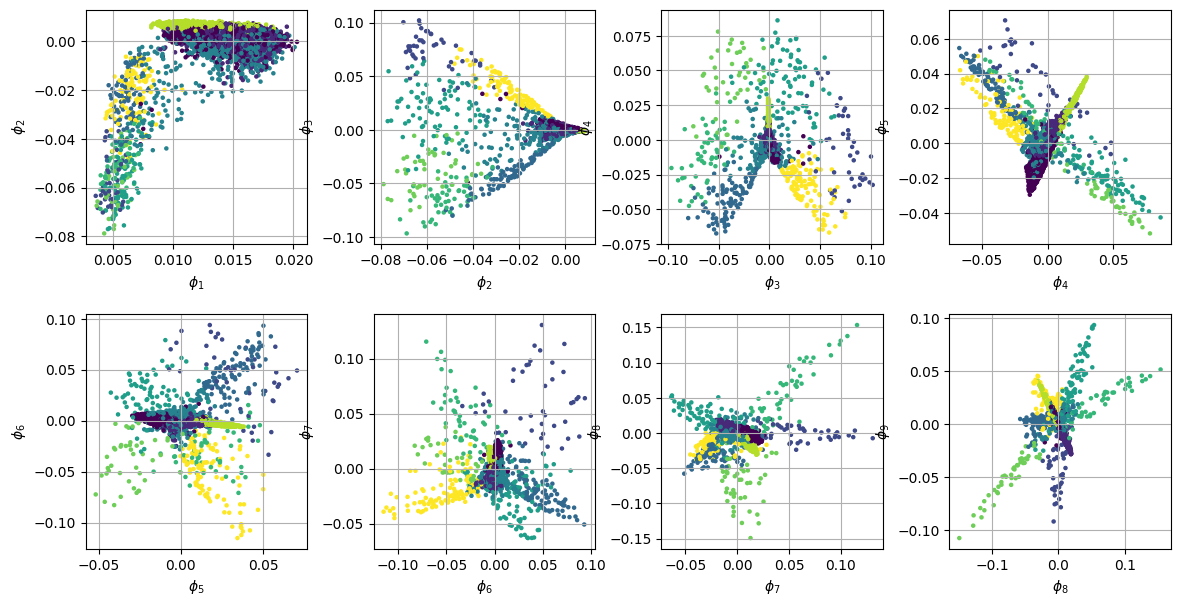

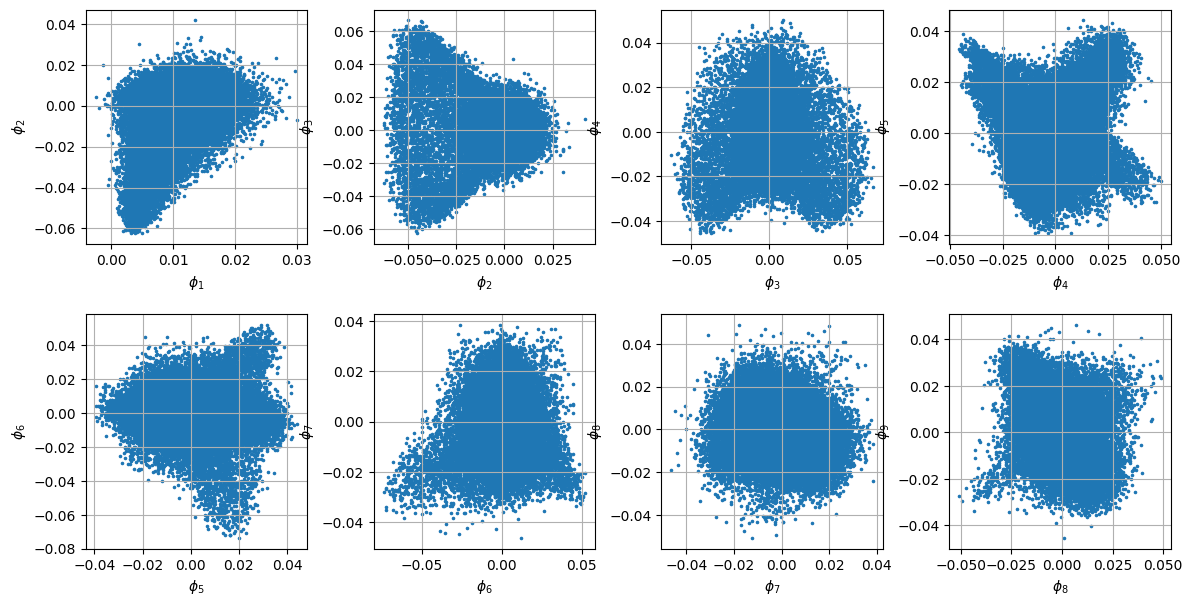

In [15]:
inds_centroids, labels = graph.cluster(n=10)

_Z_g = Z_g.detach().cpu().numpy()
_Z = Z.detach().cpu().numpy()

fig, axs = plt.subplots(2, 4, figsize=(14, 7))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(8):
    r, c = i//4, i%4
    x, y = _Z_g[:, i], _Z_g[:, i+1]
    axs[r, c].scatter(x, y, s=5, c=labels, cmap='viridis')
    axs[r, c].grid('on')
    axs[r, c].set_xlabel(fr"$\phi_{i+1}$")
    axs[r, c].set_ylabel(fr"$\phi_{i+2}$")


fig, axs = plt.subplots(2, 4, figsize=(14, 7))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(8):
    r, c = i//4, i%4
    x, y = _Z[:, i], _Z[:, i+1]
    axs[r, c].scatter(x, y, s=2.5)
    # x, y = _Z_g[:, i], _Z_g[:, i+1]
    # axs[r, c].scatter(x, y, s=5, c=labels, cmap='viridis')
    axs[r, c].grid('on')
    axs[r, c].set_xlabel(fr"$\phi_{i+1}$")
    axs[r, c].set_ylabel(fr"$\phi_{i+2}$")

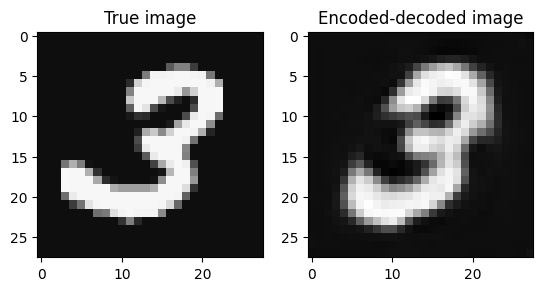

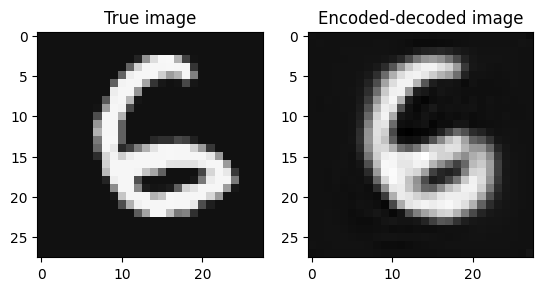

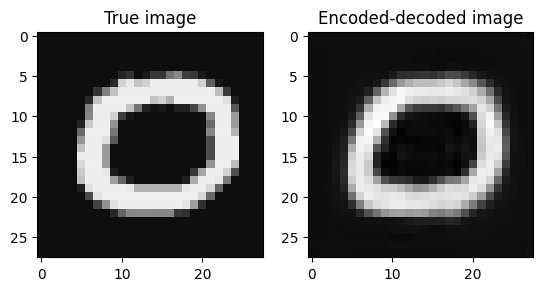

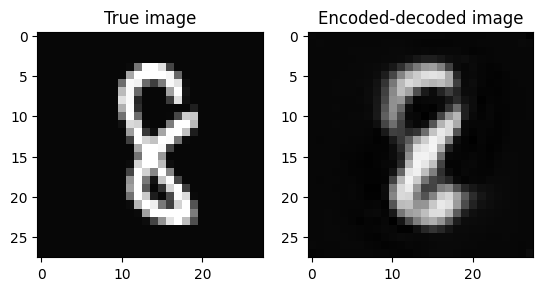

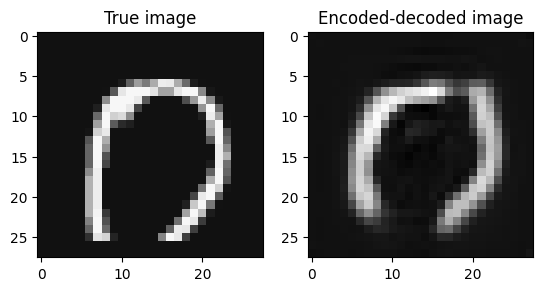

In [16]:
for _ in range(5):
    sample_ind = np.random.randint(0, X.shape[0])

    x_true = X[sample_ind, :].reshape(1, -1).cpu().numpy()
    x_hat = X_hat[sample_ind, :].detach().cpu().numpy().reshape(1, -1)

    vmin = min(x_true.min(), x_hat.min())
    vmax = max(x_true.max(), x_hat.max())

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(x_true.reshape(dim1, dim2), cmap='gray', vmin=vmin, vmax=vmax)
    ax[0].set_title('True image')
    ax[1].imshow(x_hat.reshape(dim1, dim2), cmap='gray', vmin=vmin, vmax=vmax)
    ax[1].set_title('Encoded-decoded image')


### Build model and train

In [17]:
Z_n, Z_mean, Z_std = normalize_tensor(Z)

dataloader = DataLoader(
    TensorDataset(Z_n),
    batch_size=diffusion_batch_size,
    shuffle=True
)
sample = next(iter(dataloader))[0]
in_dim = sample.shape[1]

diffusion = DiffusionProcess(
    timesteps=timesteps, beta_bounds=beta_bounds, device=device
)

model = LatentDiffusionModel(
    input_dim=in_dim,
    time_embed_dim=time_embed_dim,
    hidden_units=diffusion_hidden_units,
    dropout=diffusion_dropout,
    depth=diffusion_depth,
    use_residual=diffusion_use_residual,
    mean=Z_mean,
    std=Z_std,
    decoder=decoder,
).to(device)

count_parameters(model)

optimizer = optim.Adam(
    model.parameters(),
    lr=diffusion_learning_rate,
    weight_decay=diffusion_weight_decay,
)

criterion = nn.MSELoss()

+------------------------+------------+------------+
|        Modules         |   Shape    | Parameters |
+------------------------+------------+------------+
|   input_layer.weight   | [256, 82]  |   20992    |
|    input_layer.bias    |   [256]    |    256     |
|    input_bn.weight     |   [256]    |    256     |
|     input_bn.bias      |   [256]    |    256     |
| hidden_layers.0.weight | [256, 256] |   65536    |
|  hidden_layers.0.bias  |   [256]    |    256     |
| hidden_layers.1.weight | [256, 256] |   65536    |
|  hidden_layers.1.bias  |   [256]    |    256     |
| hidden_layers.2.weight | [256, 256] |   65536    |
|  hidden_layers.2.bias  |   [256]    |    256     |
|  hidden_bns.0.weight   |   [256]    |    256     |
|   hidden_bns.0.bias    |   [256]    |    256     |
|  hidden_bns.1.weight   |   [256]    |    256     |
|   hidden_bns.1.bias    |   [256]    |    256     |
|  hidden_bns.2.weight   |   [256]    |    256     |
|   hidden_bns.2.bias    |   [256]    |    256

In [18]:
# Training loop
loss_history = []

for epoch in range(diffusion_num_epochs):
    model.train()
    loss_epoch = 0

    for z, in dataloader:

        t = torch.randint(0, timesteps, (z.size(0),)).to(device)
        t_normalized = t / (timesteps - 1)

        # Denoising loss
        z_noisy, noise = diffusion.forward(z, t)
        predicted_noise = model(z_noisy, t_normalized)
        loss = criterion(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()

    loss_epoch /= len(dataloader)
    loss_history.append(loss_epoch)
    if (epoch + 1) % diffusion_log_interval == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_epoch}")

Epoch 100, Loss: 0.2917694479227066
Epoch 200, Loss: 0.272140109539032
Epoch 300, Loss: 0.26103557646274567
Epoch 400, Loss: 0.25120662301778796
Epoch 500, Loss: 0.2461274355649948
Epoch 600, Loss: 0.2426687091588974
Epoch 700, Loss: 0.23880622386932374
Epoch 800, Loss: 0.23832072913646699
Epoch 900, Loss: 0.2391897514462471
Epoch 1000, Loss: 0.23700190633535384
Epoch 1100, Loss: 0.23510858565568923
Epoch 1200, Loss: 0.23380245715379716
Epoch 1300, Loss: 0.23081310838460922
Epoch 1400, Loss: 0.23083646446466446
Epoch 1500, Loss: 0.22928315848112107
Epoch 1600, Loss: 0.2288758635520935
Epoch 1700, Loss: 0.229164220392704
Epoch 1800, Loss: 0.22817502170801163
Epoch 1900, Loss: 0.22834370732307435
Epoch 2000, Loss: 0.22676282972097397


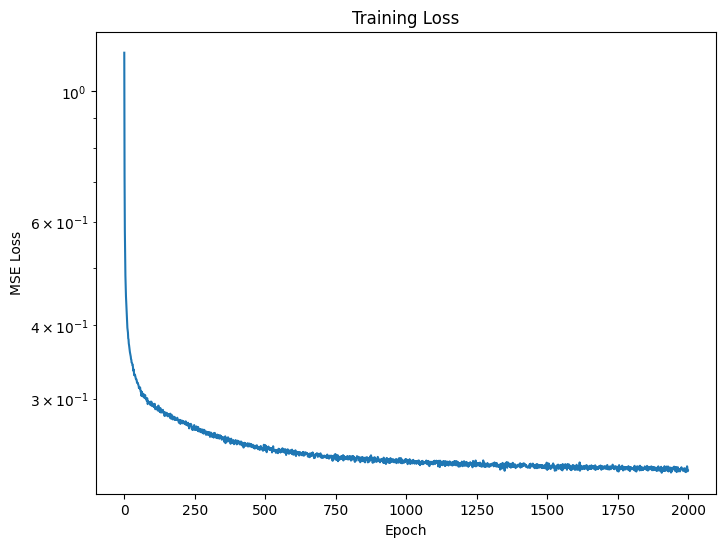

In [19]:
# plot loss
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(loss_history)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_yscale("log")

### Save model

In [20]:
experiment_name = generate_funny_name()
print(f"Experiment name: {experiment_name}")

save_experiment(model, optimizer, loss_history, config, experiment_name)
update_experiment_log(experiment_name, config)

Experiment name: quirky-sloth-20250123131338
Experiment saved in: saved_models/quirky-sloth-20250123131338
Experiment 'quirky-sloth-20250123131338' added to the log.


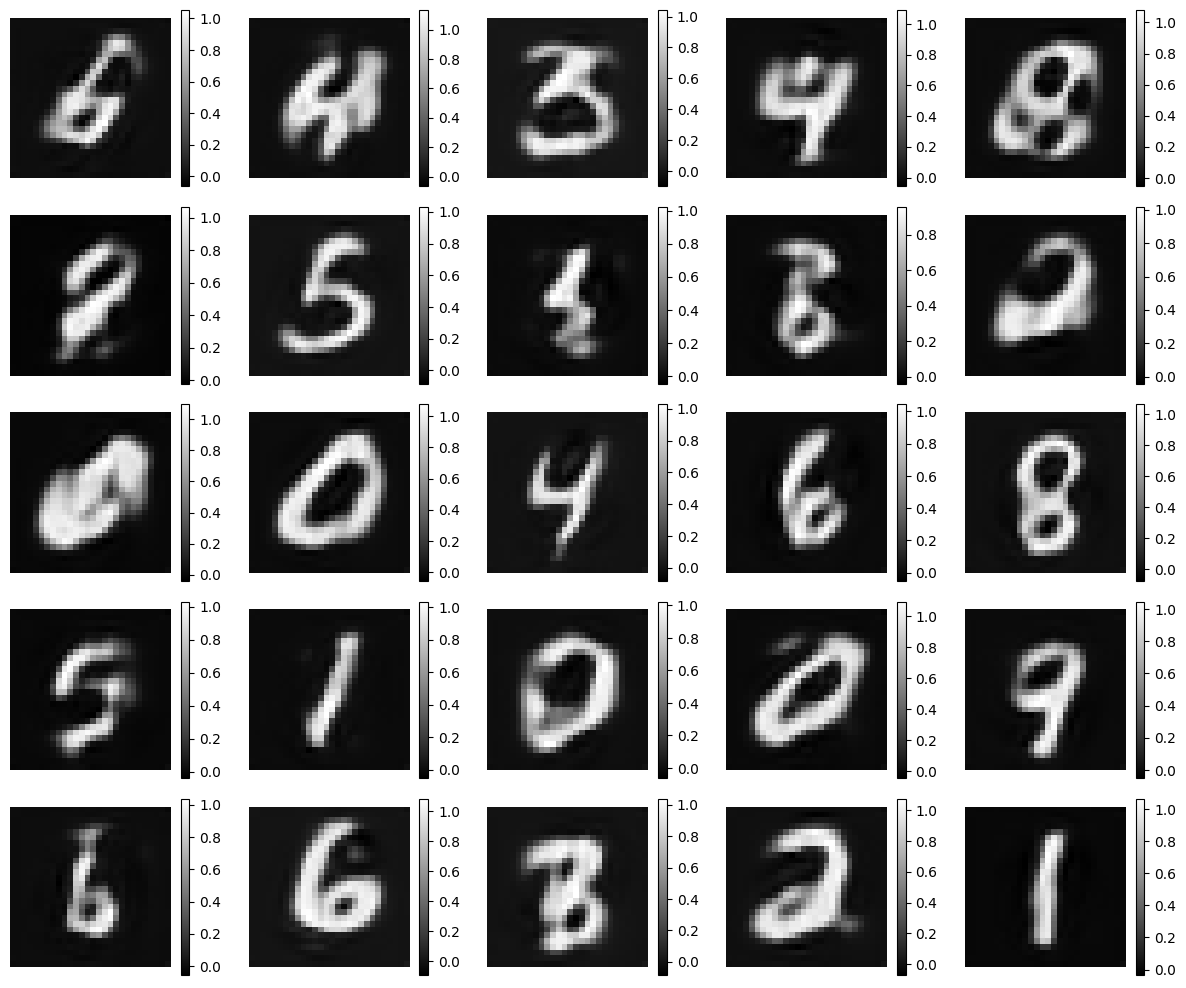

In [24]:
# Generate gaussian noise and denoise it to latent space embeddings z 
model.eval()
x_samples = diffusion.reverse(
    model,
    num_samples=25,
    in_dim=latent_dim,
    device=device,
    denormalize=True,
    decode=True,
).detach().cpu().numpy()

n_rows, n_cols = 5, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))

for i in range(n_rows * n_cols):
    ax = axes[i // n_cols, i % n_cols]
    sample = x_samples[i].reshape(dim1, dim2)
    sample_plot = ax.imshow(sample, cmap="gray")
    ax.axis("off")
    fig.colorbar(sample_plot)

plt.tight_layout()
plt.savefig(f"saved_models/{experiment_name}/samples.png")